In [11]:
import gym
import seagul.envs
import pickle
import torch.utils.data

from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PPOModel, SwitchedPPOModel, SwitchedPPOModelActHold
from seagul.nn import MLP
#torch.set_default_dtype(torch.double)
from mpl_toolkits.mplot3d import Axes3D

dtype = np.float32


#seeds = [1]; load_paths =  ['./data2/drake_double/dynamic_step' + str(seed) for seed in seeds]
#load_paths =  ['./data2/sac/asdasdasd']
load_paths = ['./data/seagul/debug20']
load_paths = ["/home/sgillen/work/seagul/seagul/notebooks/lorenz/data/seagul/saclorenz_me3/"]
env_name = 'linear_z-v0'
#seeds = [0]; load_paths = ['./data/drake_acro_final/warm_seed' + str(seed) for seed in seeds]
model, env, args, ws = load_workspace(load_paths[0])
#num_steps = ws['num_epochs']
#num_steps = 1000

seagul.rl.run_utils
seagul.rl.run_utils


Exception ignored in: <function tqdm.__del__ at 0x7f2c19768a70>
Traceback (most recent call last):
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1246, in close
    self.display(pos=0)
  File "/home/sgillen/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1397, in display
    self.sp(self.__repr__() if msg is None else msg)
  File "/home/sgillen/anaconda3/envs/drake/lib/python3.6/site-packages/tqdm/_tqdm.py", line 250, in print_status
    fp_write('\r' + s + (' ' * max(last_len[0] - len_s, 0)))
  File "/home/sgillen/anaconda3/envs/drake/lib/python3.6/site-packages/tqdm/_tqdm.py", line 243, in fp_write
    fp.write(_unicode(s))
NameError: name '_unicode' is not defined


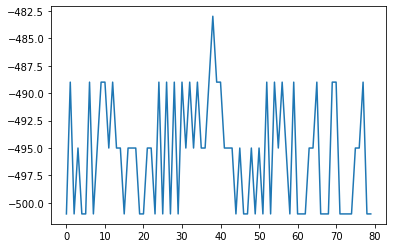

In [12]:
plt.plot(ws['raw_rew_hist'])

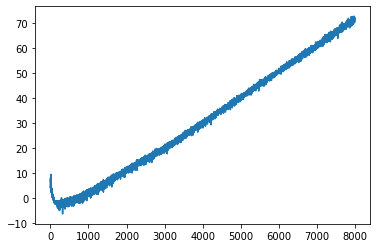

In [13]:
plt.plot(ws['pol_loss_hist'])

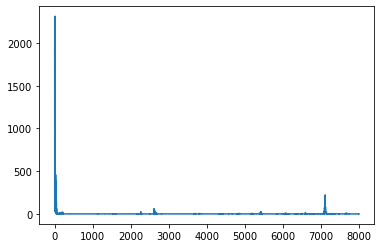

In [14]:
plt.plot(ws['val_loss_hist'])

In [15]:
env = gym.make(env_name, **ws['env_config'])
#env._max_episode_steps = 100000
#env.state_noise_max = 5.0
obs = env.reset()
obs = np.array(obs, dtype=dtype)

action_hist = []
m_act_hist = []
obs_hist = []
reward_hist = []

done = False
while not done:
    # for some algorithms you can get the sample mean out, need to change the value on the index to match your env for now
    # mean_actions = out_dict['behaviour_logits'][:17]
    # actions = trainer.compute_action(obs.flatten())
    
    sampled_actions, val, _, logp = model.step(obs.reshape(1,-1))
    actions = sampled_actions.detach().reshape(-1)
    #actions = np.zeros(3)
    #actions[0] = -obs[1]
   
    #s = 10; b = 8/3; r = 28
    #actions = np.zeros(3)
    #actions[0] = s * (obs[1] - obs[0]) + obs[0]
    #actions[1] = (r * obs[0] - obs[1] - obs[0] * obs[2]) + obs[1]
    #actions[2] = (obs[0] * obs[1] - b * obs[2]) + obs[2]
    
    obs, reward, done, _ = env.step(np.asarray(actions))
    obs = np.array(obs, dtype=dtype)
    
    # !! uncomment to render
    #env.render()
    
    action_hist.append(np.copy(actions))
    obs_hist.append(np.copy(obs))
    reward_hist.append(np.copy(reward))


    
print(sum(reward_hist))
print(len(obs_hist))

action_hist = np.stack(action_hist)
obs_hist = np.stack(obs_hist)
reward_hist = np.stack(reward_hist)

#plt.plot(action_hist)
#plt.figure()
#plt.figure()
#plt.plot(obs_hist)
#plt.figure()

-495.0
501


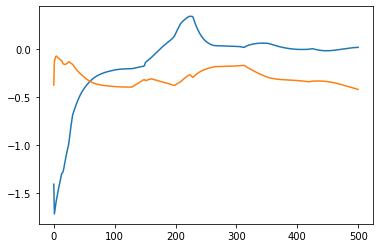

In [16]:
plt.plot(action_hist)

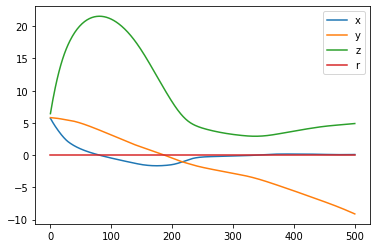

In [17]:
plt.plot(obs_hist)
plt.legend(['x', 'y', 'z', 'r'])

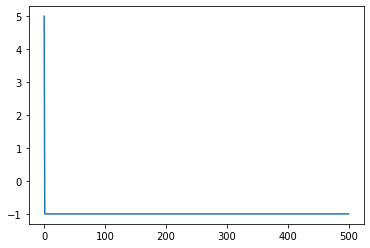

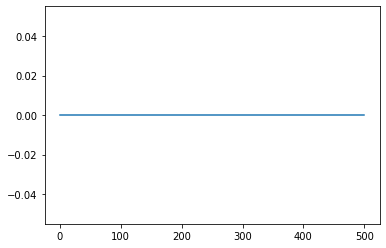

In [18]:
plt.plot(reward_hist)
plt.figure()
plt.plot(obs_hist[:,3])

Text(0.5, 0.92, 'phase diagram')

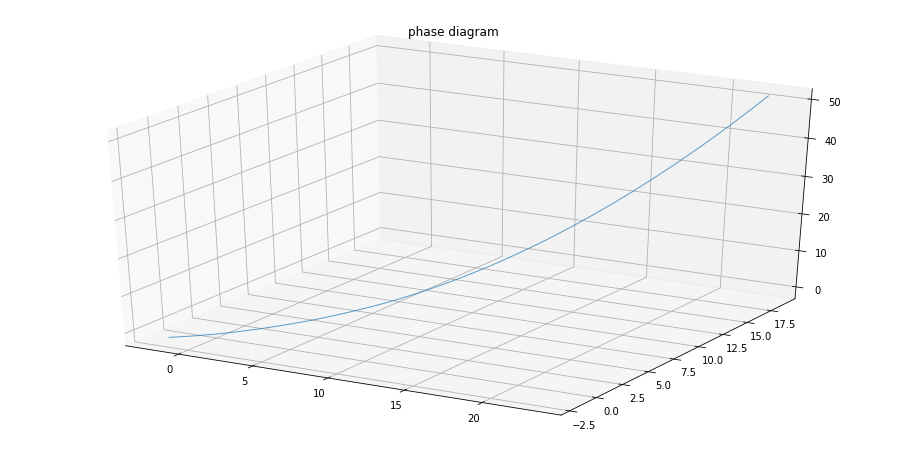

In [50]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')


total 0.315077543258667
[-194.75271999]


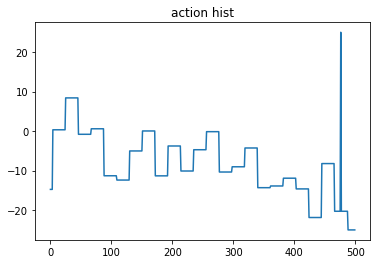

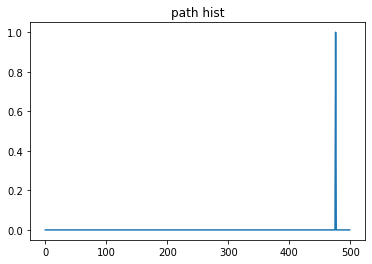

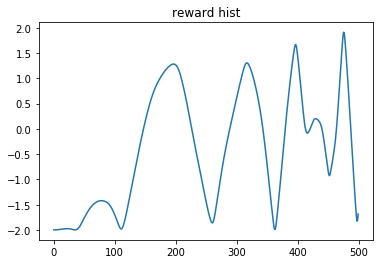

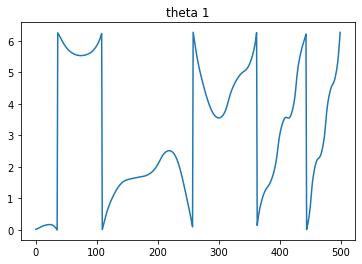

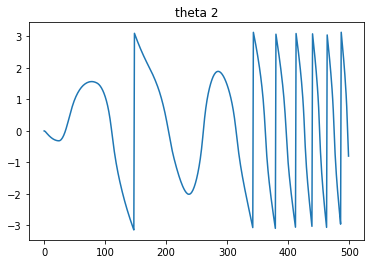

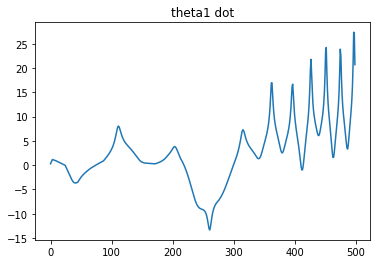

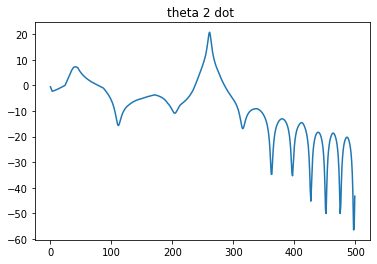

In [198]:
env = gym.make('su_acro_drake-v0')

env.num_steps = 500

def control(q):
    k =  np.array([1316.85, 555.42, 570.33, 272.58])
    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #k = 
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
path_hist = np.zeros((env.num_steps,1))


obs = env.reset(init_vec = [.02,0,0,0]) 

import time
start = time.time()
for i in range(env.num_steps):
        if(pi - 0.2 < obs[0] < pi+ 0.2 and -0.5 < obs[1] < 0.5): #and abs(obs[2]) < 1 and abs(obs[3] < 1)):
            actions = np.clip(np.asarray(control(obs)), -25,25)
            path_hist[i] = 1
        else:
            actions, _, _, logp = model.step(torch.as_tensor(obs, dtype=torch.float32).reshape(1,-1))
            path_hist[i] = 0

        actions =  np.clip(actions, -25, 25)
        obs, reward, done, _ = env.step(actions)
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
       # if done:
       #     break
            
print("total", time.time() - start)

plt.plot(action_hist)
plt.title('action hist')

plt.figure()
plt.plot(path_hist)
plt.title('path hist')

plt.figure()
plt.plot(reward_hist)
plt.title('reward hist')

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta 1")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("theta 2")

plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta1 dot")

plt.figure()
plt.plot(state_hist[:,3])
plt.title("theta 2 dot ")

print(sum(reward_hist))